In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import ast, json

from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from mlxtend.regressor import StackingRegressor
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMRegressor

data = pd.read_csv("https://raw.githubusercontent.com/jennymoskowitz/JCP/master/Competition/Train.csv")

In [ ]:
data.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [ ]:
train = data[["Distance (KM)", "Temperature","Precipitation in millimeters","Time from Pickup to Arrival"]]
train.head()

,Distance (KM),Temperature,Precipitation in millimeters,Time from Pickup to Arrival
0,4,20.4,NaN,745
1,16,26.4,NaN,1993
2,3,NaN,NaN,455
3,9,19.2,NaN,1341
4,9,15.4,NaN,1214


In [ ]:
train.columns = ["distance", "temp", "prec", "target"]
train.head()

,distance,temp,prec,target
0,4,20.4,NaN,745
1,16,26.4,NaN,1993
2,3,NaN,NaN,455
3,9,19.2,NaN,1341
4,9,15.4,NaN,1214


In [ ]:
X = train.drop(["target"], axis=1)
X.head()

,distance,temp,prec
0,4,20.4,NaN
1,16,26.4,NaN
2,3,NaN,NaN
3,9,19.2,NaN
4,9,15.4,NaN


In [ ]:
Y = train["target"]
Y.head()

0     745
1    1993
2     455
3    1341
4    1214
Name: target, dtype: int64

In [ ]:
X.isna().sum()

distance        0
temp         4366
prec        20649
dtype: int64

In [ ]:
X["prec"] = X["prec"].fillna(0)

In [ ]:
X = X.fillna(X.mean())

In [ ]:
X.head()

,distance,temp,prec
0,4,20.400000,0.0
1,16,26.400000,0.0
2,3,23.258889,0.0
3,9,19.200000,0.0
4,9,15.400000,0.0


In [ ]:
RESULTS = {}

In [ ]:
def evaluate_model(estimator):
    cv_results = cross_validate(estimator,
                    X=X,
                    y=Y,
                    scoring=["neg_mean_absolute_error", "r2"],
                          n_jobs=-1, cv=4,
                     return_train_score=True)
    return pd.DataFrame(cv_results).abs().mean().to_dict()

In [ ]:
def display_results(results):
    results_df  = pd.DataFrame(results).T
    results_cols = results_df.columns
    for col in results_df:
        results_df[col] = results_df[col].apply(np.mean)
    return results_df

In [ ]:
#model testing
RESULTS["tree"] = evaluate_model(DecisionTreeRegressor())
RESULTS["tree2"] = evaluate_model(DecisionTreeRegressor(max_depth=6))
RESULTS["lm"] = evaluate_model(LinearRegression())
RESULTS["elasticnet"] = evaluate_model(ElasticNet()) 
RESULTS["lasso"] = evaluate_model(Lasso()) 
RESULTS["ridge"] = evaluate_model(Ridge())


display_results(RESULTS)

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_r2,train_r2
tree,0.042992,0.004482,629.468387,465.792049,0.165590,0.500533
tree2,0.019859,0.003152,556.827224,548.308770,0.333098,0.356882
lm,0.008315,0.002763,556.105836,555.919099,0.336927,0.337278
elasticnet,0.008216,0.002547,556.720113,556.521774,0.336853,0.337197
lasso,0.008058,0.002865,556.121347,555.933070,0.336927,0.337278
ridge,0.008192,0.002669,556.105907,555.919169,0.336927,0.337278


In [ ]:
#stacking
estimator_stacking = StackingRegressor(
    regressors=[
        DecisionTreeRegressor(),
        LinearRegression(),
        ElasticNet()
    ], 
    meta_regressor=LinearRegression())


RESULTS["stacking"]  = evaluate_model(estimator_stacking)
display_results(RESULTS)

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_r2,train_r2
tree,0.042992,0.004482,629.468387,465.792049,0.165590,0.500533
tree2,0.019859,0.003152,556.827224,548.308770,0.333098,0.356882
lm,0.008315,0.002763,556.105836,555.919099,0.336927,0.337278
elasticnet,0.008216,0.002547,556.720113,556.521774,0.336853,0.337197
lasso,0.008058,0.002865,556.121347,555.933070,0.336927,0.337278
ridge,0.008192,0.002669,556.105907,555.919169,0.336927,0.337278
stacking,0.063082,0.006553,629.099322,465.792049,0.166449,0.500533


In [ ]:
#random forest
RESULTS["randomforest_100"] = evaluate_model(RandomForestRegressor(n_estimators=100))
display_results(RESULTS)

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_r2,train_r2
tree,0.039639,0.004075,629.192340,465.792049,0.166334,0.500533
lm,0.008477,0.002898,556.105836,555.919099,0.336927,0.337278
elasticnet,0.007299,0.002413,556.720113,556.521774,0.336853,0.337197
lasso,0.006398,0.002495,556.121347,555.933070,0.336927,0.337278
ridge,0.007694,0.002580,556.105907,555.919169,0.336927,0.337278
tree2,0.020690,0.003051,556.795007,548.308770,0.333198,0.356882
stacking,0.062730,0.007084,628.880256,465.792049,0.167140,0.500533
randomforest_100,2.439884,0.149903,607.425322,487.921413,0.230222,0.488249
bagging_10,0.263927,0.018727,613.866533,491.889863,0.213778,0.477343


In [ ]:
#bagging e.g. decision trees
RESULTS["bagging_10"] = evaluate_model(BaggingRegressor(n_estimators=10))
display_results(RESULTS)

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_r2,train_r2
tree,0.039639,0.004075,629.192340,465.792049,0.166334,0.500533
lm,0.008477,0.002898,556.105836,555.919099,0.336927,0.337278
elasticnet,0.007299,0.002413,556.720113,556.521774,0.336853,0.337197
lasso,0.006398,0.002495,556.121347,555.933070,0.336927,0.337278
ridge,0.007694,0.002580,556.105907,555.919169,0.336927,0.337278
tree2,0.020690,0.003051,556.795007,548.308770,0.333198,0.356882
stacking,0.062730,0.007084,628.880256,465.792049,0.167140,0.500533
randomforest_100,2.439884,0.149903,607.425322,487.921413,0.230222,0.488249
bagging_10,0.254591,0.018266,614.517093,492.234858,0.214688,0.477812


In [ ]:
#bagging e.g. elastic net
estimator_bagging_elnet = BaggingRegressor(n_estimators=100, 
                                           base_estimator=ElasticNet())
RESULTS["bagging_elnet"] = evaluate_model(estimator_bagging_elnet)
display_results(RESULTS)

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_r2,train_r2
tree,0.039639,0.004075,629.192340,465.792049,0.166334,0.500533
lm,0.008477,0.002898,556.105836,555.919099,0.336927,0.337278
elasticnet,0.007299,0.002413,556.720113,556.521774,0.336853,0.337197
lasso,0.006398,0.002495,556.121347,555.933070,0.336927,0.337278
ridge,0.007694,0.002580,556.105907,555.919169,0.336927,0.337278
tree2,0.020690,0.003051,556.795007,548.308770,0.333198,0.356882
stacking,0.062730,0.007084,628.880256,465.792049,0.167140,0.500533
randomforest_100,2.439884,0.149903,607.425322,487.921413,0.230222,0.488249
bagging_10,0.254591,0.018266,614.517093,492.234858,0.214688,0.477812
bagging_elnet,0.473371,0.020023,556.743323,556.546732,0.336873,0.337205


In [ ]:
#extremely random trees
estimator_bagging_random_tree = BaggingRegressor(n_estimators=100,
                                    base_estimator=ExtraTreeRegressor())
RESULTS["bagging_random_tree"] = evaluate_model(estimator_bagging_random_tree)
display_results(RESULTS)

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_r2,train_r2
tree,0.039639,0.004075,629.192340,465.792049,0.166334,0.500533
lm,0.008477,0.002898,556.105836,555.919099,0.336927,0.337278
elasticnet,0.007299,0.002413,556.720113,556.521774,0.336853,0.337197
lasso,0.006398,0.002495,556.121347,555.933070,0.336927,0.337278
ridge,0.007694,0.002580,556.105907,555.919169,0.336927,0.337278
tree2,0.020690,0.003051,556.795007,548.308770,0.333198,0.356882
stacking,0.062730,0.007084,628.880256,465.792049,0.167140,0.500533
randomforest_100,2.439884,0.149903,607.425322,487.921413,0.230222,0.488249
bagging_10,0.254591,0.018266,614.517093,492.234858,0.214688,0.477812
bagging_elnet,0.473371,0.020023,556.743323,556.546732,0.336873,0.337205


In [ ]:
#ada boost
estimator_adaboost = AdaBoostRegressor(n_estimators=100)

RESULTS["adaboost_100"]  = evaluate_model(estimator_adaboost)
display_results(RESULTS)

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_r2,train_r2
tree,0.039639,0.004075,629.192340,465.792049,0.166334,0.500533
lm,0.008477,0.002898,556.105836,555.919099,0.336927,0.337278
elasticnet,0.007299,0.002413,556.720113,556.521774,0.336853,0.337197
lasso,0.006398,0.002495,556.121347,555.933070,0.336927,0.337278
ridge,0.007694,0.002580,556.105907,555.919169,0.336927,0.337278
tree2,0.020690,0.003051,556.795007,548.308770,0.333198,0.356882
stacking,0.062730,0.007084,628.880256,465.792049,0.167140,0.500533
randomforest_100,2.439884,0.149903,607.425322,487.921413,0.230222,0.488249
bagging_10,0.254591,0.018266,614.517093,492.234858,0.214688,0.477812
bagging_elnet,0.473371,0.020023,556.743323,556.546732,0.336873,0.337205


In [ ]:
#xgboost
estimator_xgboost = XGBRegressor(n_estimators=500)

RESULTS["xgboost_500"] = evaluate_model(estimator_xgboost)

display_results(RESULTS)

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_r2,train_r2
tree,0.009393,0.003852,552.316127,550.589886,0.343787,0.347637
tree2,0.008348,0.003498,552.341762,550.943318,0.343710,0.347022
lm,0.005991,0.002584,556.180680,556.070698,0.336981,0.337153
elasticnet,0.005550,0.002546,556.782812,556.668414,0.336898,0.337072
lasso,0.005290,0.002289,556.191694,556.081618,0.336981,0.337153
ridge,0.004603,0.002689,556.180750,556.070767,0.336981,0.337153
xgboost_500,2.921316,0.082394,552.363650,550.589936,0.343712,0.347637


[21:37:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


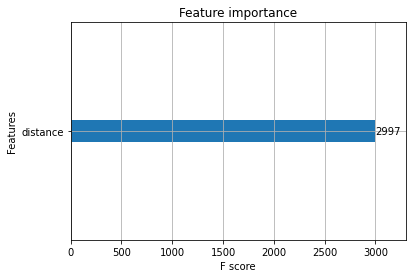

In [ ]:
estimator_xgboost.fit(X, Y);
plot_importance(estimator_xgboost);